<a href="https://colab.research.google.com/github/kzebibi/EDA/blob/main/Healthcare_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'healthcare-dataset-2019-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5521808%2F9142418%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240819%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240819T084738Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D53cf74ef4fc501f44f4cacf55d94fbfc0172ea149a965a2a1606ca5c22556394d2e2c692268e63cbef5a30a7431ca7846ee726a1067797a7f62928407b5eb152b658a54ad98e0b388f580f3dca1c76210f314d1e7489d977107cc2468f4eefbbbabdf11983ff3a0fc73438666d128dab24786ce3869e05154d203c0a239d3dcd67f035e4783eb143cfe688ac0b3a2e1feb945a39cf0eaa5e6a23a36e1558869d08904bfd29c7e84a266c728ead2451f4fe00a0436084bd740e63b8db71ded355354f2f41fedaf1ab063f1cb4767fe642defbad11f28ea32295e3222b97a398dab3d1d16137438d7685ecc846172ed21752b787ab332cfa4f5c3a336272e21fb5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3054550 bytes downloaded
Downloaded and uncompressed: healthcare-dataset-2019-2024
Data source import complete.


In [183]:
# Importing the neccessary libraries
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go

## Data Exploration and Cleaning

## Load Data

In [184]:
import pandas as pd
df = pd.read_csv('/kaggle/input/healthcare-dataset-2019-2024/healthcare_dataset.csv')

## Initial Exploration

In [185]:
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

In [187]:
df.isnull().sum()

,0
Name,0
Age,0
Gender,0
Blood Type,0
Medical Condition,0
Date of Admission,0
Doctor,0
Hospital,0
Insurance Provider,0
Billing Amount,0


In [188]:
df.duplicated().sum()

534

In [189]:
df.nunique()

,0
Name,49992
Age,77
Gender,2
Blood Type,8
Medical Condition,6
Date of Admission,1827
Doctor,40341
Hospital,39876
Insurance Provider,5
Billing Amount,50000


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

In [191]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,55500.0,51.539459,19.602454,13.00000,35.000000,52.000000,68.000000,89.000000
Billing Amount,55500.0,25539.316097,14211.454431,-2008.49214,13241.224652,25538.069376,37820.508436,52764.276736
Room Number,55500.0,301.134829,115.243069,101.00000,202.000000,302.000000,401.000000,500.000000


In [192]:
df['Test Results'].value_counts()

,count
Test Results,
Abnormal,18627
Normal,18517
Inconclusive,18356


## Visualization

### Basic countplots

Gender
Male      27774
Female    27726
Name: count, dtype: int64


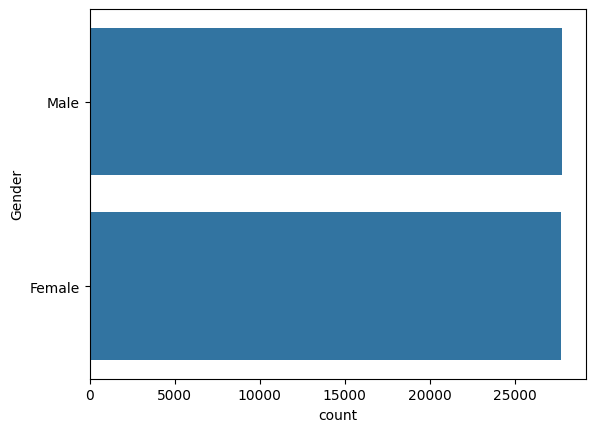

-----------------------------------
Blood Type
A-     6969
A+     6956
AB+    6947
AB-    6945
B+     6945
B-     6944
O+     6917
O-     6877
Name: count, dtype: int64


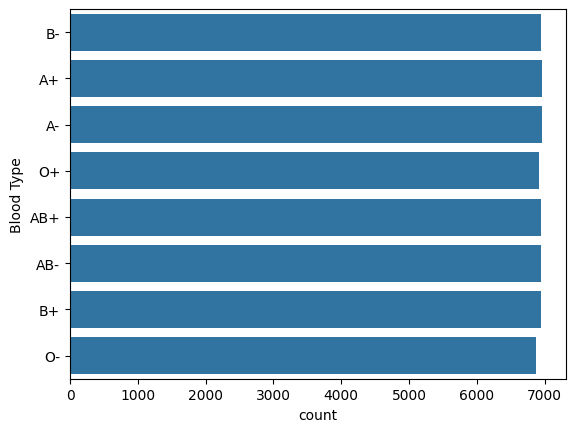

-----------------------------------
Medical Condition
Arthritis       9308
Diabetes        9304
Hypertension    9245
Obesity         9231
Cancer          9227
Asthma          9185
Name: count, dtype: int64


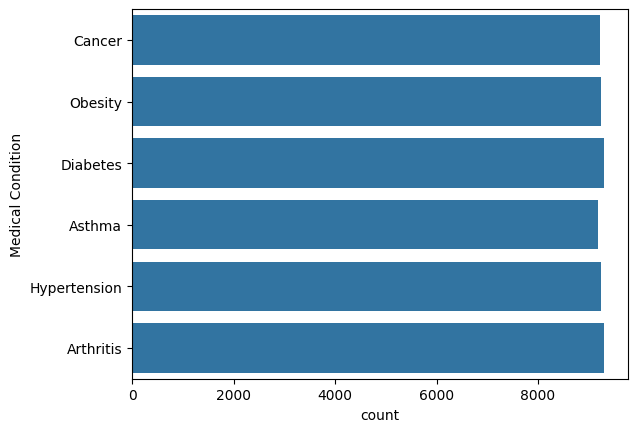

-----------------------------------
Insurance Provider
Cigna               11249
Medicare            11154
UnitedHealthcare    11125
Blue Cross          11059
Aetna               10913
Name: count, dtype: int64


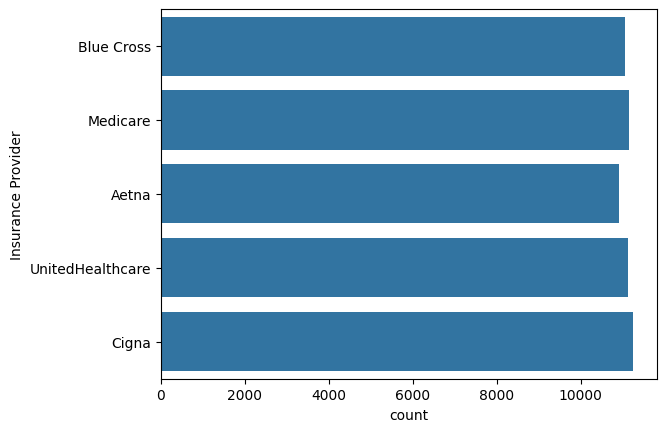

-----------------------------------
Admission Type
Elective     18655
Urgent       18576
Emergency    18269
Name: count, dtype: int64


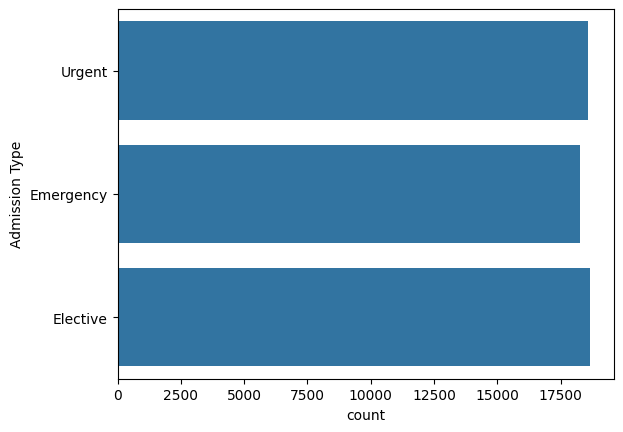

-----------------------------------
Medication
Lipitor        11140
Ibuprofen      11127
Aspirin        11094
Paracetamol    11071
Penicillin     11068
Name: count, dtype: int64


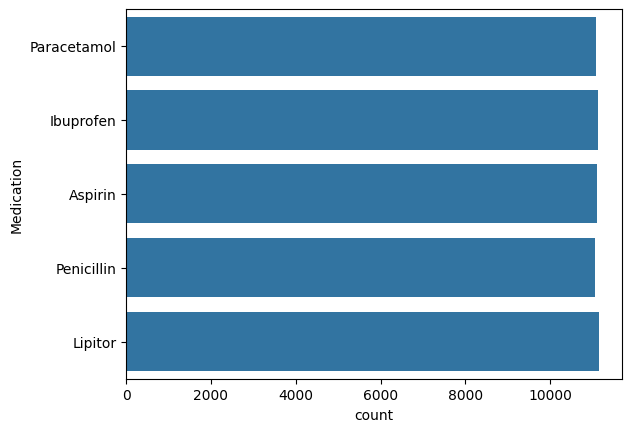

-----------------------------------
Test Results
Abnormal        18627
Normal          18517
Inconclusive    18356
Name: count, dtype: int64


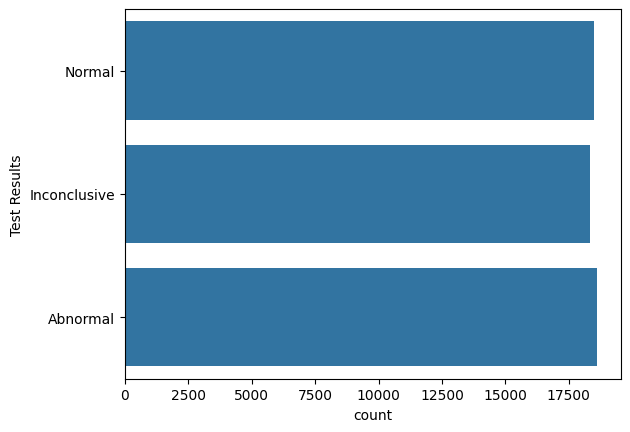

-----------------------------------


In [193]:
for col in df:
    if col  in ['Doctor', 'Hospital', 'Name', 'Date of Admission', 'Discharge Date']:
        pass
    elif df[col].dtype == 'O':
        print(df[col].value_counts())
        sns.countplot(y=col,data=df)
        plt.show()
        print('-----------------------------------')


<Axes: xlabel='Medical Condition', ylabel='count'>

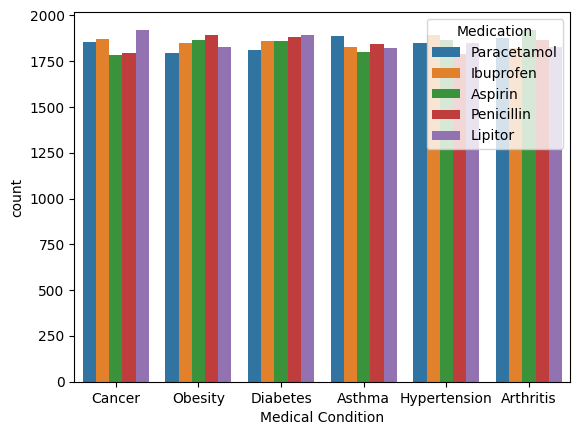

In [194]:
sns.countplot(x='Medical Condition', hue='Medication', data=df)

<Axes: xlabel='Medical Condition', ylabel='count'>

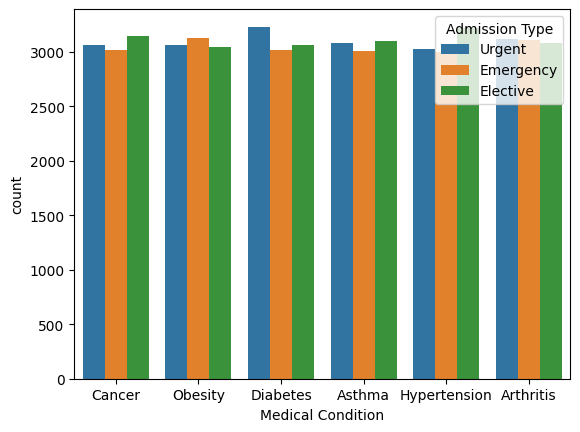

In [195]:
sns.countplot(x='Medical Condition', hue='Admission Type', data=df)

### Medical condition and admission type

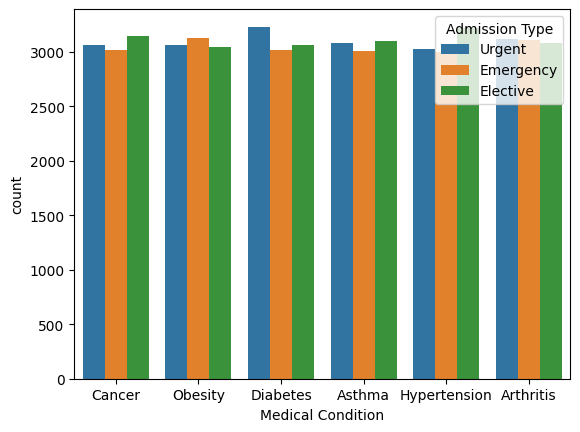

In [196]:
sns.countplot(x='Medical Condition', hue='Admission Type', data=df)
plt.show()

### Billing amount range for each medical condition

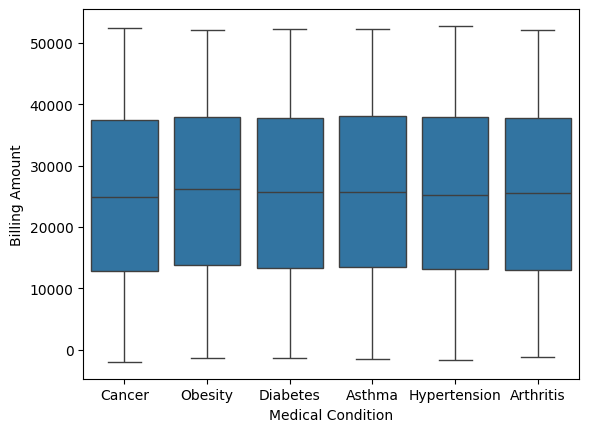

In [197]:
sns.boxplot(x='Medical Condition', y='Billing Amount', data=df)
plt.show()

### Medications count for each medical condition

In [198]:
df['Medication'].unique()

array(['Paracetamol', 'Ibuprofen', 'Aspirin', 'Penicillin', 'Lipitor'],
      dtype=object)

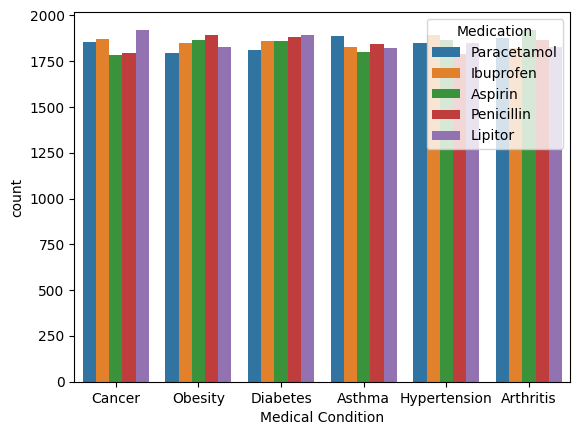

In [199]:
sns.countplot(x='Medical Condition', hue='Medication', data=df)
plt.show()

### Stacked bar plot for Gender vs. Medical Condition

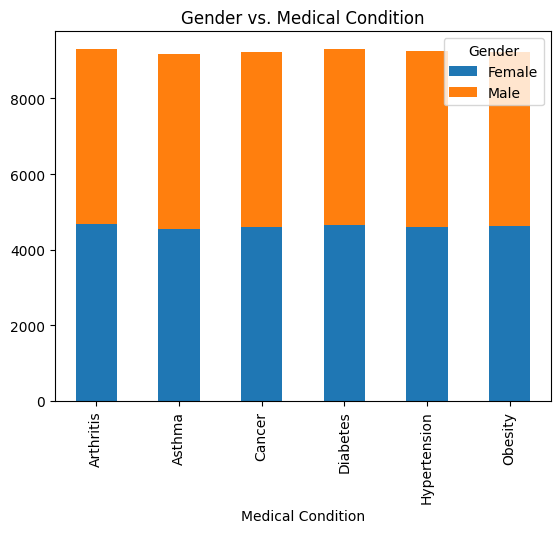

In [200]:
df.groupby(['Medical Condition', 'Gender']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Gender vs. Medical Condition')
plt.show()

### Scatterplot for test results with medical conditions and bills

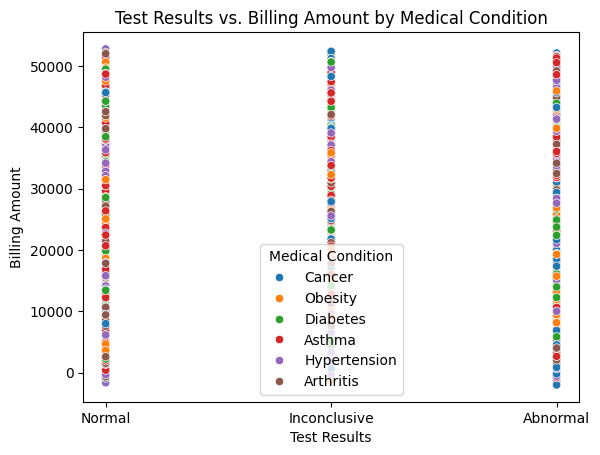

In [201]:
sns.scatterplot(x='Test Results', y='Billing Amount', hue='Medical Condition', data=df)
plt.title('Test Results vs. Billing Amount by Medical Condition')
plt.show()

### Gender vs Age

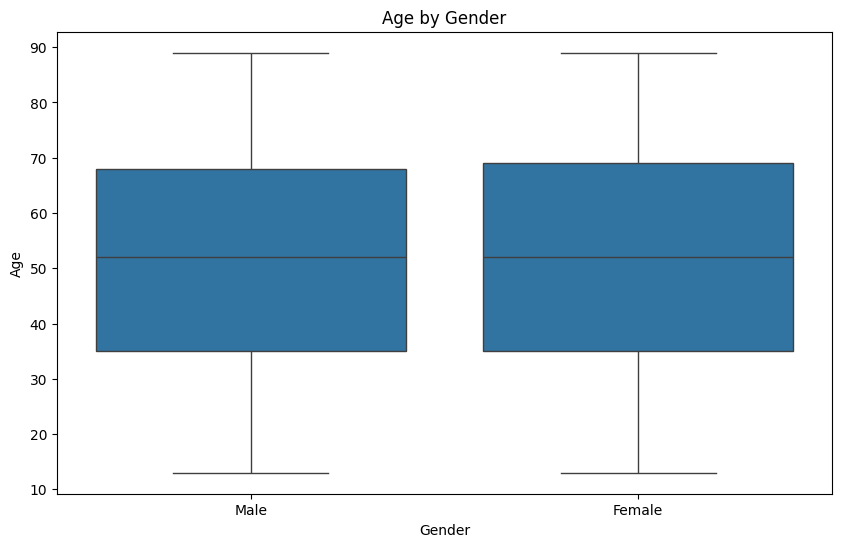

In [202]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Age', data=df)
plt.title('Age by Gender')
plt.show()

### Pairplot between Medical condition and [age, billing amount]

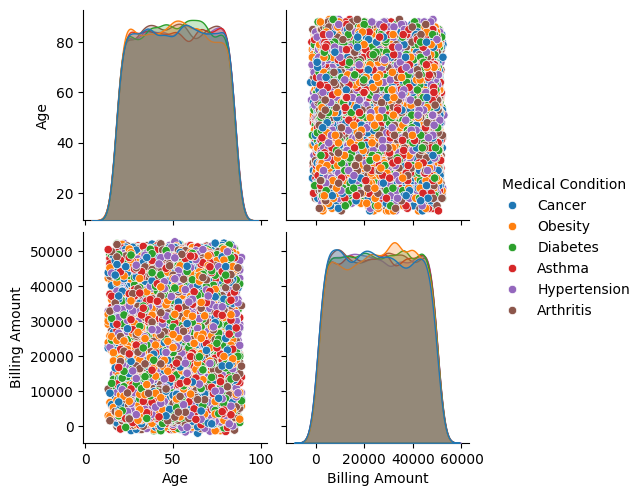

In [203]:
sns.pairplot(df, hue='Medical Condition', vars=['Age', 'Billing Amount'])
plt.show()

### How long does patient stays

In [204]:
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
# patient Stay duration
df['Stay duration'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

In [205]:
#  Stay duration column value count graph
stay_counts = df['Stay duration'].value_counts()

# Create the bar graph using plotly.express
fig = px.bar(stay_counts, x=stay_counts.index, y=stay_counts.values,
             labels={'x':'Stay Duration (Days)', 'y':'Number of Patients'})
fig.show()


### Billing Amount, Age, Length stay

In [206]:
# grouped = df.groupby('Medical Condition').agg({'Billing Amount': 'mean', 'Age': 'mean', 'Length of Stay': 'mean'})
# grouped.plot(kind='bar', figsize=(12, 6))
# plt.title('Mean Billing Amount, Age, and Length of Stay by Medical Condition')
# plt.show()

### Box Plot

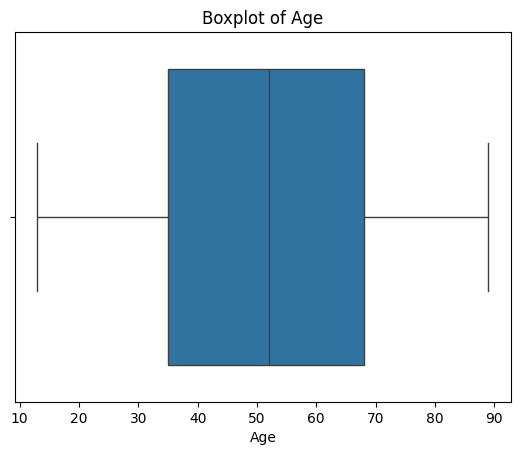

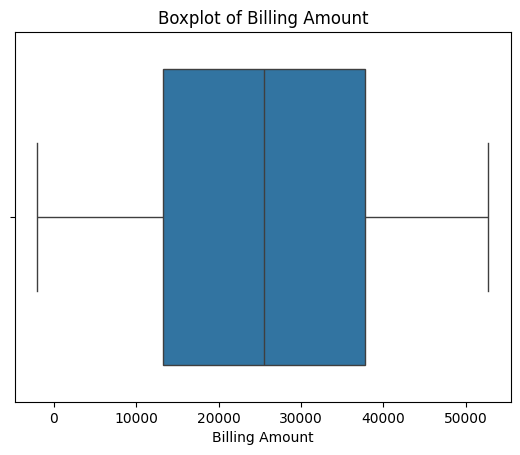

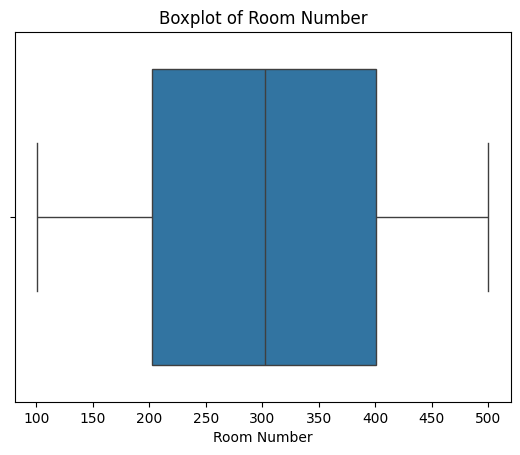

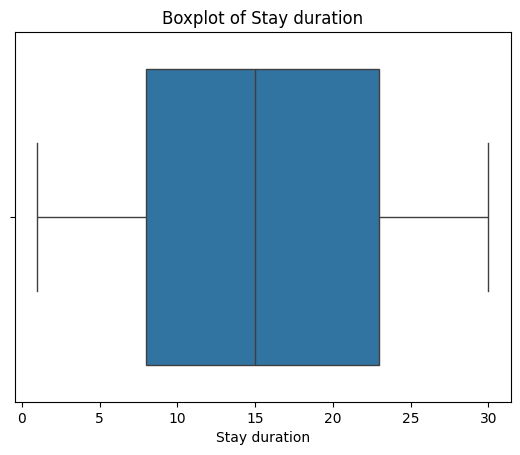

In [207]:
# Iterate through numerical columns and create boxplots
for column in df.select_dtypes(include=['number']):
    plt.figure()  # Create a new figure for each plot
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


<Axes: xlabel='Gender', ylabel='Age'>

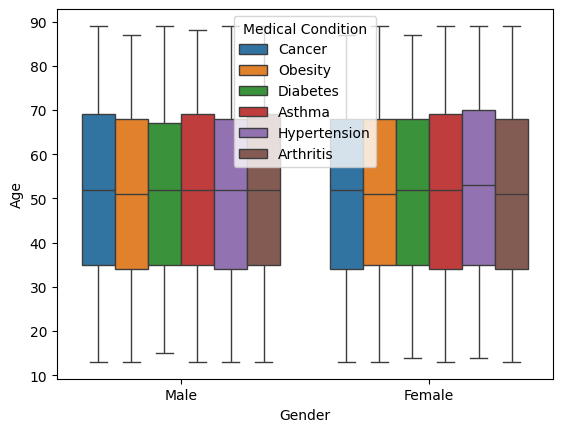

In [208]:
sns.boxplot(x='Gender', y='Age',hue='Medical Condition', data=df)

<Axes: xlabel='Gender', ylabel='Billing Amount'>

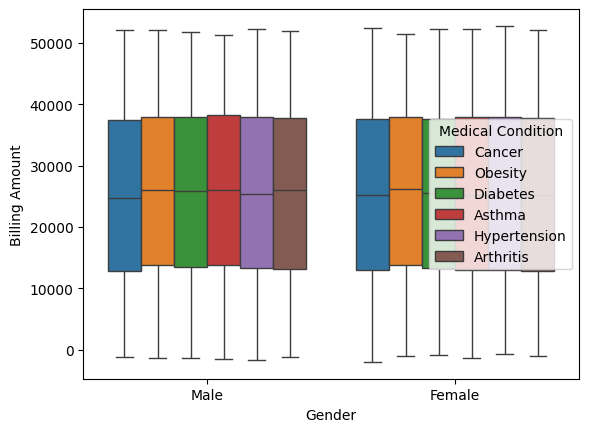

In [209]:
sns.boxplot(x='Gender', y='Billing Amount',hue='Medical Condition', data=df)

In [210]:
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Stay duration
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal,2
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive,6
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal,15
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal,30
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal,20


## Data Cleaning

In [211]:
df = df.drop(['Name', 'Doctor', 'Hospital', 'Date of Admission', 'Discharge Date'], axis=1)
df.head()


,Age,Gender,Blood Type,Medical Condition,Insurance Provider,Billing Amount,Room Number,Admission Type,Medication,Test Results,Stay duration
0,30,Male,B-,Cancer,Blue Cross,18856.281306,328,Urgent,Paracetamol,Normal,2
1,62,Male,A+,Obesity,Medicare,33643.327287,265,Emergency,Ibuprofen,Inconclusive,6
2,76,Female,A-,Obesity,Aetna,27955.096079,205,Emergency,Aspirin,Normal,15
3,28,Female,O+,Diabetes,Medicare,37909.782410,450,Elective,Ibuprofen,Abnormal,30
4,43,Female,AB+,Cancer,Aetna,14238.317814,458,Urgent,Penicillin,Abnormal,20


In [165]:
# import pandas as pd
# # Assuming 'Insurance Provider' and 'Test Results' are categorical
# contingency_table = pd.crosstab(df['Insurance Provider'], df['Test Results'])

# # Calculate the Chi-squared test statistic and p-value
# from scipy.stats import chi2_contingency
# chi2, p, dof, expected = chi2_contingency(contingency_table)

# print(f"Chi-squared statistic: {chi2}")
# print(f"P-value: {p}")

# # Interpret the results (example)
# if p < 0.05:
#     print("There is a significant association between Insurance Provider and Test Results.")
# else:
#     print("There is no significant association between Insurance Provider and Test Results.")


Chi-squared statistic: 8.37755432208288
P-value: 0.3974847786991828
There is no significant association between Insurance Provider and Test Results.


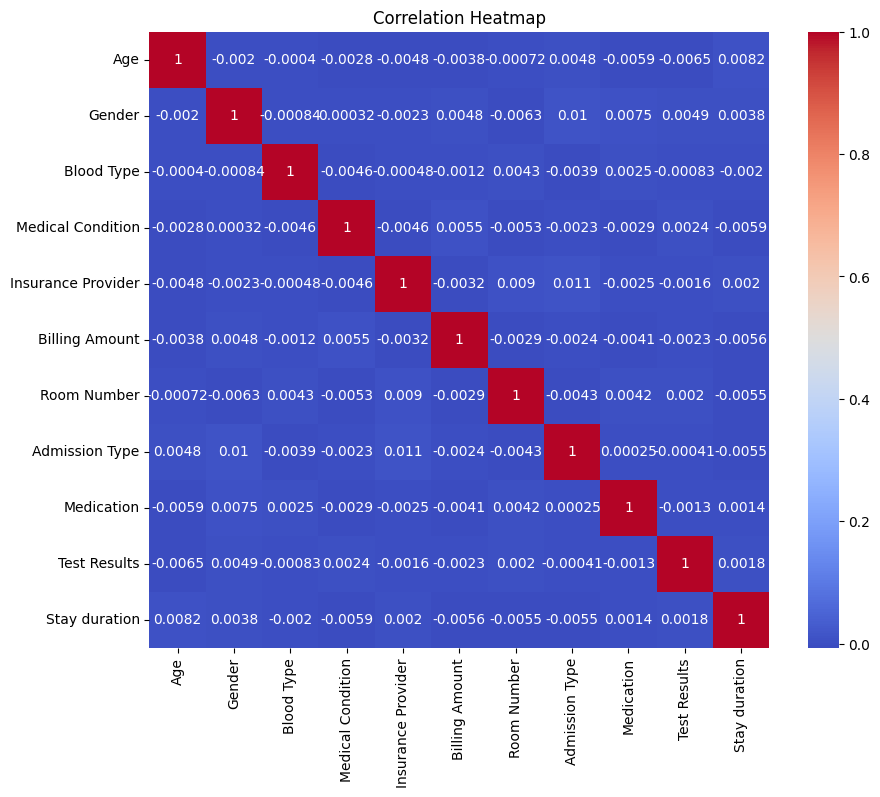

In [168]:
# # Select categorical columns for encoding
# categorical_cols = ['Gender', 'Admission Type', 'Insurance Provider',
#                     'Medical Condition', 'Medication', 'Test Results', 'Blood Type'] # Include 'Test Results'

# # Apply label encoding to categorical features
# label_encoder = LabelEncoder()
# for col in categorical_cols:
#     df[col] = label_encoder.fit_transform(df[col])

# # Calculate correlations
# corr_matrix = df.corr()

# # Create a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap')
# plt.show()

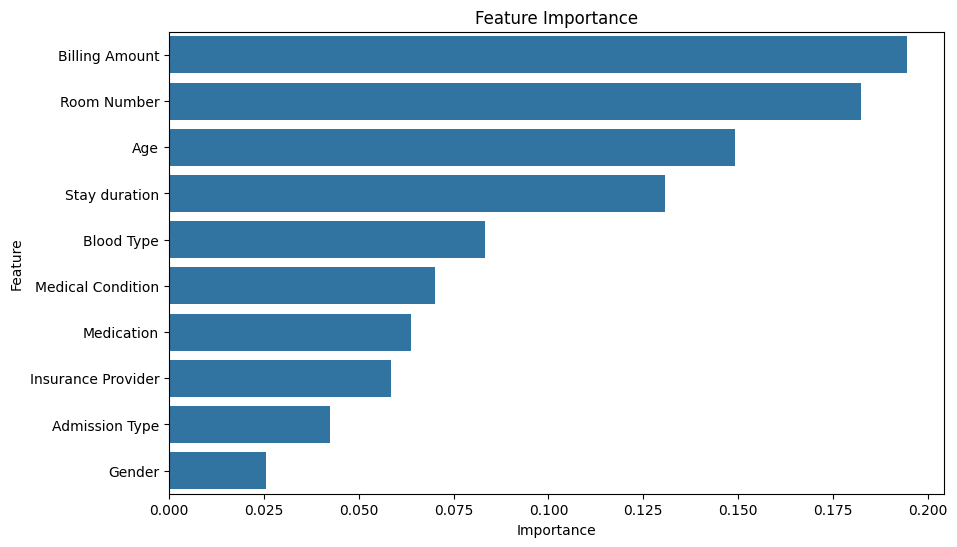

In [170]:
# # Assuming 'Billing Amount' is your target variable
# X = df.drop('Test Results', axis=1)
# y = df['Test Results']

# # Initialize a Random Forest Classifier
# model = RandomForestClassifier()

# # Fit the model
# model.fit(X, y)

# # Get feature importances
# importances = model.feature_importances_

# # Create a DataFrame for visualization
# feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# feature_importances = feature_importances.sort_values('Importance', ascending=False)

# # Plot feature importances
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=feature_importances)
# plt.title('Feature Importance')
# plt.show()


In [212]:
df.drop_duplicates(inplace=True)

In [213]:
df.shape

(54966, 11)

In [214]:
df.nunique()

,0
Age,77
Gender,2
Blood Type,8
Medical Condition,6
Insurance Provider,5
Billing Amount,50000
Room Number,400
Admission Type,3
Medication,5
Test Results,3


## Feature Engineering


In [215]:
# One-hot encode categorical features
df = pd.get_dummies(df, columns=['Gender', 'Blood Type', 'Medical Condition',
                                  'Insurance Provider', 'Admission Type', 'Medication'], drop_first=True)
df.head()


,Age,Billing Amount,Room Number,Test Results,Stay duration,Gender_Male,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,Blood Type_B+,...,Insurance Provider_Blue Cross,Insurance Provider_Cigna,Insurance Provider_Medicare,Insurance Provider_UnitedHealthcare,Admission Type_Emergency,Admission Type_Urgent,Medication_Ibuprofen,Medication_Lipitor,Medication_Paracetamol,Medication_Penicillin
0,30,18856.281306,328,Normal,2,True,False,False,False,False,...,True,False,False,False,False,True,False,False,True,False
1,62,33643.327287,265,Inconclusive,6,True,False,False,False,False,...,False,False,True,False,True,False,True,False,False,False
2,76,27955.096079,205,Normal,15,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,28,37909.782410,450,Abnormal,30,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
4,43,14238.317814,458,Abnormal,20,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54966 entries, 0 to 55499
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age                                  54966 non-null  int64  
 1   Billing Amount                       54966 non-null  float64
 2   Room Number                          54966 non-null  int64  
 3   Test Results                         54966 non-null  object 
 4   Stay duration                        54966 non-null  int64  
 5   Gender_Male                          54966 non-null  bool   
 6   Blood Type_A-                        54966 non-null  bool   
 7   Blood Type_AB+                       54966 non-null  bool   
 8   Blood Type_AB-                       54966 non-null  bool   
 9   Blood Type_B+                        54966 non-null  bool   
 10  Blood Type_B-                        54966 non-null  bool   
 11  Blood Type_O+                    

In [217]:
# label incoding for Test results
le = LabelEncoder()
df['Test Results'] = le.fit_transform(df['Test Results'])
df.head()


,Age,Billing Amount,Room Number,Test Results,Stay duration,Gender_Male,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,Blood Type_B+,...,Insurance Provider_Blue Cross,Insurance Provider_Cigna,Insurance Provider_Medicare,Insurance Provider_UnitedHealthcare,Admission Type_Emergency,Admission Type_Urgent,Medication_Ibuprofen,Medication_Lipitor,Medication_Paracetamol,Medication_Penicillin
0,30,18856.281306,328,2,2,True,False,False,False,False,...,True,False,False,False,False,True,False,False,True,False
1,62,33643.327287,265,1,6,True,False,False,False,False,...,False,False,True,False,True,False,True,False,False,False
2,76,27955.096079,205,2,15,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,28,37909.782410,450,0,30,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
4,43,14238.317814,458,0,20,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True


In [218]:
le.classes_

array(['Abnormal', 'Inconclusive', 'Normal'], dtype=object)

## Data Splitting

In [219]:
X = df.drop('Test Results', axis=1)
y = df['Test Results']


In [220]:
print(X.shape)
print(y.shape)

(54966, 27)
(54966,)


In [221]:
#split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [222]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (43972, 27)
X_test shape: (10994, 27)
y_train shape: (43972,)
y_test shape: (10994,)


### Scaling

In [223]:
# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Training

### Models

In [43]:
!pip install wolta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.5 MB/s eta 0:00:00


In [224]:
from wolta.model_tools import compare_models

results = compare_models('clf',
                        ['ada', 'cat', 'lbm', 'raf', 'ext', 'dtr', 'per', 'rdg'],
                        ['acc', 'precision'],
                        X_train, y_train, X_test, y_test,
                        get_result=True)

AdaBoost
Accuracy Score: 0.3336365290158268
Precision Score: 0.33474221289471023
***
CatBoost
Accuracy Score: 0.3614698926687284
Precision Score: 0.36150315211160156
***
LightGBM
Accuracy Score: 0.36083318173549206
Precision Score: 0.3613763291441656
***
Random Forest
Accuracy Score: 0.42750591231580864
Precision Score: 0.4281806367500274
***
Extra Tree
Accuracy Score: 0.4188648353647444
Precision Score: 0.41906998914383536
***
Decision Tree
Accuracy Score: 0.4094960887756958
Precision Score: 0.40953178218275094
***
Perceptron
Accuracy Score: 0.33600145533927595
Precision Score: 0.33583630338985543
***
Ridge
Accuracy Score: 0.33309077678733856
Precision Score: 0.33370131298318706
***


In [225]:
from wolta.model_tools import get_best_model

model = get_best_model(results, 'acc', 'clf', X_train, y_train, behavior='max-best')
y_pred = model.predict(X_test)

Best Algorithm is raf with the score of 0.42750591231580864


In [226]:
from sklearn.metrics import classification_report as rep

print(rep(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.45      0.43      3616
           1       0.43      0.41      0.42      3682
           2       0.43      0.41      0.42      3696

    accuracy                           0.42     10994
   macro avg       0.42      0.42      0.42     10994
weighted avg       0.42      0.42      0.42     10994



### Logistic Regression

In [94]:
# Logistic Regression with Cross-Validation
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5)
grid_lr.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for Logistic Regression:", grid_lr.best_params_)
print("Best cross-validation score for Logistic Regression:", grid_lr.best_score_)


Best parameters for Logistic Regression: {'C': 0.001}
Best cross-validation score for Logistic Regression: 0.3331208924168282


In [95]:
# Predictions and evaluation
y_pred_lr = grid_lr.predict(X_test)
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))


Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.33      0.47      0.39      3616
           1       0.34      0.23      0.28      3682
           2       0.34      0.30      0.32      3696

    accuracy                           0.33     10994
   macro avg       0.34      0.33      0.33     10994
weighted avg       0.34      0.33      0.33     10994



### Support Vector Machine

In [ ]:
# Support Vector Machine with Cross-Validation
param_grid_svm = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for SVM:", grid_svm.best_params_)
print("Best cross-validation score for SVM:", grid_svm.best_score_)


In [ ]:
# Predictions and evaluation
y_pred_svm = grid_svm.predict(X_test)
print("Classification Report for Support Vector Machine:\n", classification_report(y_test, y_pred_svm))

### Random Forest

In [227]:
# Random Forest with Cross-Validation
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best cross-validation score for Random Forest:", grid_rf.best_score_)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Best cross-validation score for Random Forest: 0.4131036575534795


In [228]:
# Predictions and evaluation
y_pred_rf = grid_rf.predict(X_test)
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.42      0.46      0.44      3616
           1       0.43      0.41      0.42      3682
           2       0.43      0.42      0.42      3696

    accuracy                           0.43     10994
   macro avg       0.43      0.43      0.43     10994
weighted avg       0.43      0.43      0.43     10994



### XGBClassifier

In [229]:
# Install xgboost if not already installed
!pip install xgboost

# Import the necessary library
from xgboost import XGBClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [230]:
# XGBoost with Cross-Validation
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}
grid_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5)
grid_xgb.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for XGBoost:", grid_xgb.best_params_)
print("Best cross-validation score for XGBoost:", grid_xgb.best_score_)

Best parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200}
Best cross-validation score for XGBoost: 0.3919540236424054


In [231]:
# Predictions and evaluation
y_pred_xgb = grid_xgb.predict(X_test)
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.40      0.42      0.41      3616
           1       0.41      0.39      0.40      3682
           2       0.41      0.40      0.40      3696

    accuracy                           0.40     10994
   macro avg       0.40      0.40      0.40     10994
weighted avg       0.40      0.40      0.40     10994

